In [7]:
# Base

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import json
import missingno as msno
import seaborn as sns
import pathlib as pl
import random
from collections import defaultdict

# Recommender system

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp
import implicit
from implicit.als import AlternatingLeastSquares

# MLFlow

import mlflow
import mlflow.sklearn

c:\Users\adrie\Documents\ML\article_recommendation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data preparation and EDA

In [8]:
"""
Data loading
"""

clicks_sample_df = pd.read_csv('../data/clicks_sample.csv')
metadata_df = pd.read_csv('../data/articles_metadata.csv')

with open(r'..\data\articles_embeddings.pickle', 'rb') as f:
    articles_embeddings = pickle.load(f)

CLICK_FILES_PATHS = pl.Path('../data/clicks').rglob('*.csv')
all_clicks_df = pd.concat((pd.read_csv(file) for file in CLICK_FILES_PATHS), ignore_index=True)

print("Embeddings shape:", articles_embeddings.shape)
print("Clicks sample shape:", clicks_sample_df.shape)
print("Metadata shape:", metadata_df.shape)
print("All clicks columns:", all_clicks_df.columns)
print("All clicks shape:", all_clicks_df.shape)

Embeddings shape: (364047, 250)
Clicks sample shape: (1883, 12)
Metadata shape: (364047, 5)
All clicks columns: Index(['user_id', 'session_id', 'session_start', 'session_size',
       'click_article_id', 'click_timestamp', 'click_environment',
       'click_deviceGroup', 'click_os', 'click_country', 'click_region',
       'click_referrer_type'],
      dtype='object')
All clicks shape: (2988181, 12)


- all_clicks_df preprocessing

In [9]:
columns_to_drop = ['session_id', 'session_start', 'session_size', 'click_timestamp', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 'click_region', 'click_referrer_type']
all_clicks_df = all_clicks_df.drop(columns=columns_to_drop)
print("Remaining all_cliks_df columns:", all_clicks_df.columns)

Remaining all_cliks_df columns: Index(['user_id', 'click_article_id'], dtype='object')


- Content-based filtering mapping

In [10]:
article_ids = metadata_df['article_id'].tolist()
article2idx_cb = {article_id: idx for idx, article_id in enumerate(article_ids)}
idx2article_cb = {idx: article_id for article_id, idx in article2idx_cb.items()}

- Split

In [11]:
train_df, test_df = train_test_split(all_clicks_df, test_size=0.2, random_state=42)
print(f"Training interactions: {len(train_df)}; Test interactions: {len(test_df)}")

Training interactions: 2390544; Test interactions: 597637


## 1.1 Metadata_df EDA

<Axes: >

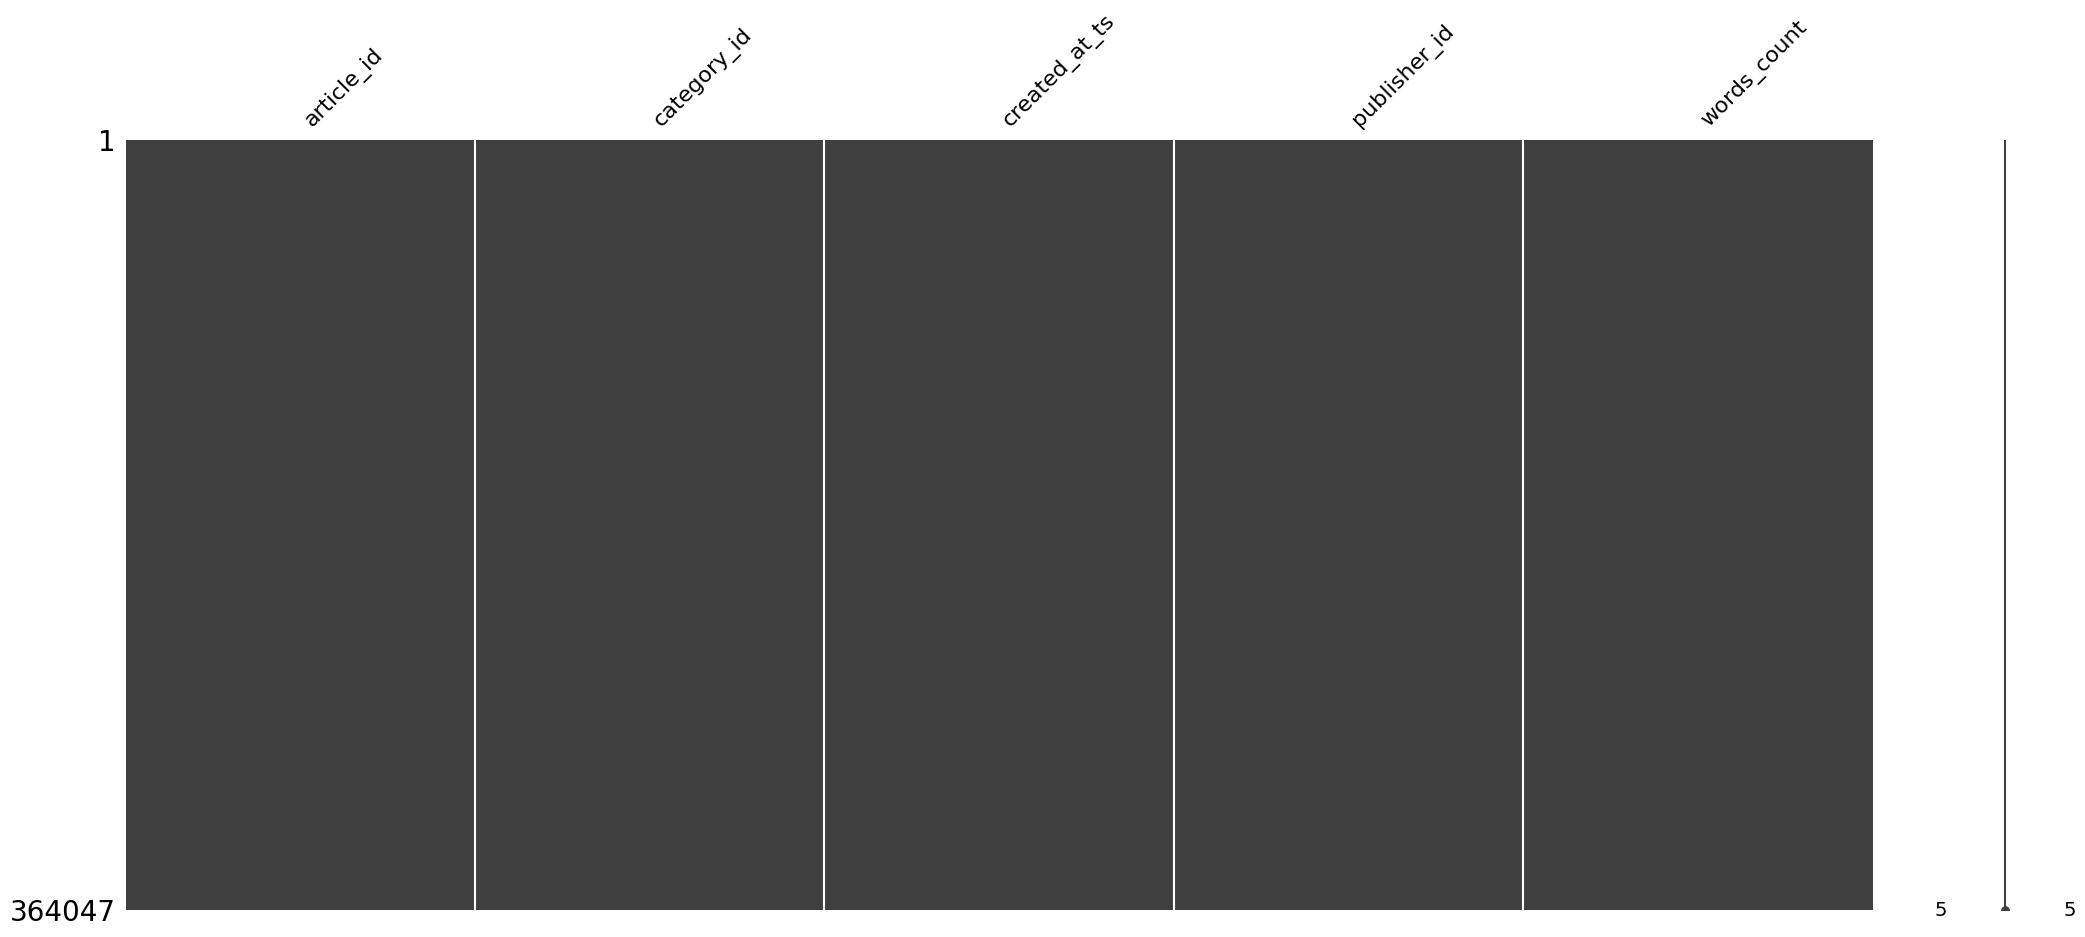

In [6]:
msno.matrix(metadata_df)

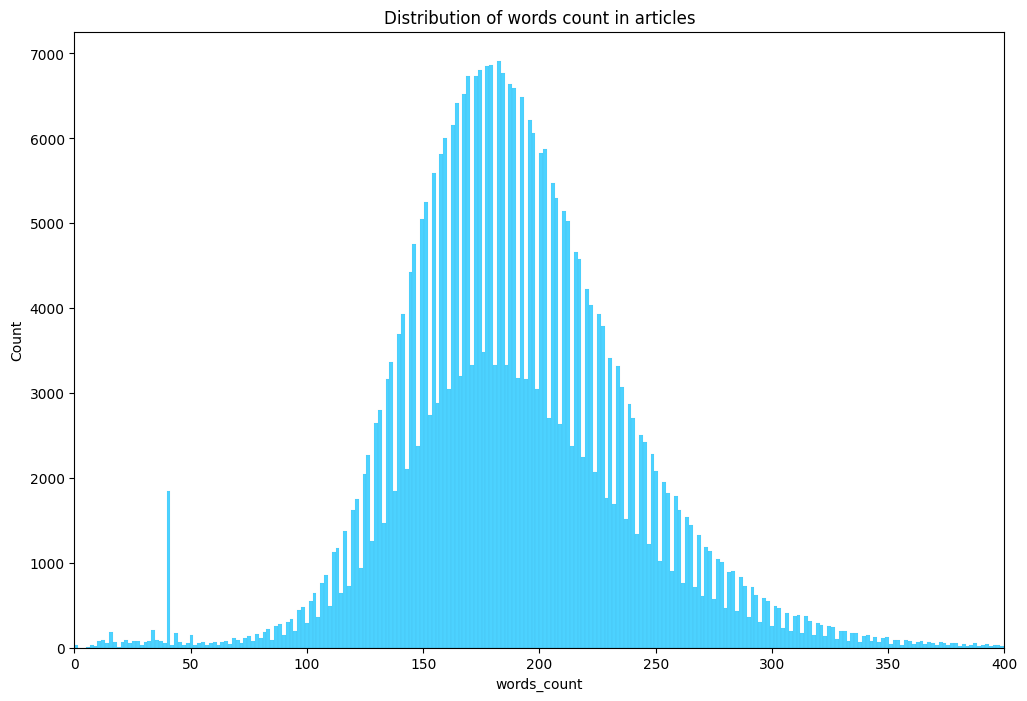

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(metadata_df['words_count'],
            color="deepskyblue",
            edgecolor="black",
            alpha=0.7,
            ax=ax)

plt.xlim([0,400])
plt.title('Distribution of words count in articles');
plt.show()



In [8]:
metadata_df['words_count'].describe()

count    364047.000000
mean        190.897727
std          59.502766
min           0.000000
25%         159.000000
50%         186.000000
75%         218.000000
max        6690.000000
Name: words_count, dtype: float64

In [9]:
print(f'Empty article(s) : {metadata_df[metadata_df["words_count"] == 0].count()[0]}')

Empty article(s) : 35


C:\Users\adrie\AppData\Local\Temp\ipykernel_4528\3150090292.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Empty article(s) : {metadata_df[metadata_df["words_count"] == 0].count()[0]}')


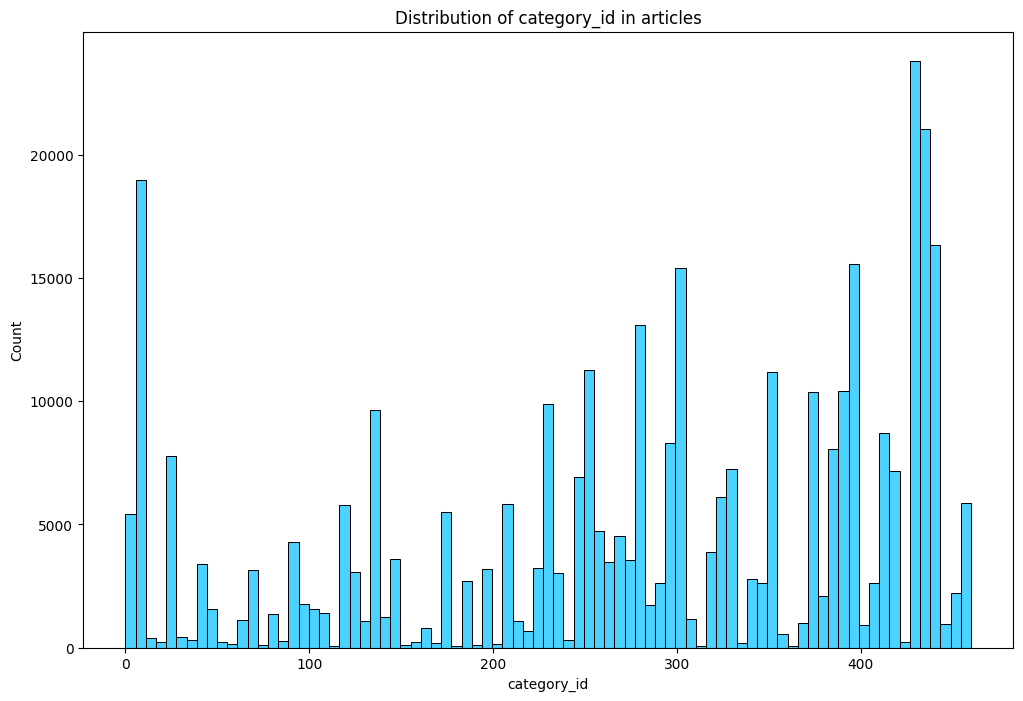

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(metadata_df['category_id'],
            color="deepskyblue",
            edgecolor="black",
            alpha=0.7,
            ax=ax)

plt.title('Distribution of category_id in articles');
plt.show()



# Collaborative Filtering (CF) model

In [4]:
def train_cf_model(train_df, factors=50, regularization=0.1, iterations=20):
    unique_users = train_df['user_id'].unique()
    unique_articles = train_df['click_article_id'].unique()
    
    user2idx = {int(user): idx for idx, user in enumerate(unique_users)}
    article2idx = {int(article): idx for idx, article in enumerate(unique_articles)}
    
    row_indices = train_df['user_id'].map(lambda x: user2idx[int(x)]).to_numpy()
    col_indices = train_df['click_article_id'].map(lambda x: article2idx[int(x)]).to_numpy()
    data = np.ones(len(train_df))
    
    user_item_matrix = sp.coo_matrix(
        (data, (row_indices, col_indices)),
        shape=(len(unique_users), len(unique_articles))
    ).tocsr()
    
    item_user_matrix = user_item_matrix.T.tocsr()
    
    cf_model = AlternatingLeastSquares(
        factors=factors,
        regularization=regularization,
        iterations=iterations
    )
    cf_model.fit(item_user_matrix)
    
    return cf_model, user2idx, article2idx, user_item_matrix

In [5]:
def get_popular_articles(user_item_matrix, article2idx, num_articles):
    article_popularity = user_item_matrix.sum(axis=0).A1
    
    idx2article = {idx: int(article) for article, idx in article2idx.items()}
    
    popular_article_indices = np.argsort(-article_popularity)
    
    popular_articles = [
        idx2article[idx]
        for idx in popular_article_indices[:num_articles]
        if idx in idx2article
    ]
    
    return popular_articles

In [6]:
def get_cf_recommendations(user_id, model, user2idx, article2idx, user_item_matrix, n_items=5):
    user_id = int(user_id)
    if user_id not in user2idx:
        return []
    
    user_idx = user2idx[user_id]
    item_ids, scores = model.recommend(
        user_idx,
        user_item_matrix[user_idx],
        N=n_items,
        filter_already_liked_items=True
    )
    
    idx2article = {idx: int(article) for article, idx in article2idx.items()}
    recommended_articles = [
        idx2article[int(idx)]
        for idx in item_ids
        if int(idx) in idx2article
    ]
    
    if len(recommended_articles) < n_items:
        popular_articles = get_popular_articles(user_item_matrix, article2idx, n_items - len(recommended_articles))
        recommended_articles.extend(popular_articles)

    return recommended_articles[:n_items]

In [ ]:
cf_model, user2idx_cf, article2idx_cf, user_item_matrix_cf = train_cf_model(train_df)

# Content based filtering

In [13]:
def build_user_profile(user_id, clicks_df, article2idx, embeddings):
    """
    Builds a user profile by averaging the embeddings of articles the user interacted with.
    Only interactions in the training data are used.
    """
    user_articles = clicks_df[clicks_df['user_id'] == user_id]['click_article_id'].unique()
    article_vectors = []
    for article_id in user_articles:
        if article_id in article2idx:
            idx = article2idx[article_id]
            article_vectors.append(embeddings[idx])
    if not article_vectors:
        return np.zeros((1, embeddings.shape[1]))
    return np.mean(article_vectors, axis=0, keepdims=True)

In [14]:
def get_cb_recommendations(user_id, clicks_df, article2idx, idx2article, embeddings, n_items=5):
    """
    Recommend articles for a user based on cosine similarity between the user profile
    and all article embeddings.
    """
    user_profile = build_user_profile(user_id, clicks_df, article2idx, embeddings)
    similarity_scores = cosine_similarity(user_profile, embeddings).flatten()
    
    # Exclude articles the user has already seen in training.
    seen_articles = set(clicks_df[clicks_df['user_id'] == user_id]['click_article_id'])
    seen_indices = {article2idx[a] for a in seen_articles if a in article2idx}
    
    ranked_indices = np.argsort(similarity_scores)[::-1]
    recommended_indices = [idx for idx in ranked_indices if idx not in seen_indices][:n_items]
    recommended_articles = [idx2article[idx] for idx in recommended_indices]
    return recommended_articles

# Evaluation

In [15]:
def build_test_dict(test_df):
    user2items = defaultdict(set)
    for row in test_df.itertuples():
        user2items[row.user_id].add(row.click_article_id)
    return user2items

user2test_items = build_test_dict(test_df)

In [16]:
def evaluate_model(get_recommendations_fn, train_df, test_df, users, **kwargs):
    """
    Computes average Precision@5 and Recall@5 for the provided recommendation function.
    The recommendation function should be able to generate recommendations given a user ID.
    """
    precision_scores = []
    recall_scores = []
    for user in users:
        # Ground truth: articles the user interacted with in the test set.
        true_items = user2test_items.get(user, set())
        if not true_items:
            continue
        recommended_items = get_recommendations_fn(user, **kwargs)
        if not recommended_items:
            continue
        hits = len(set(recommended_items) & true_items)
        precision = hits / len(recommended_items)
        recall = hits / len(true_items)
        precision_scores.append(precision)
        recall_scores.append(recall)
    return np.mean(precision_scores) if precision_scores else 0, np.mean(recall_scores) if recall_scores else 0

In [17]:
test_users = [
    int(u) for u in test_df['user_id'].unique() 
    if int(u) in user2idx_cf and user2idx_cf[int(u)] < len(cf_model.user_factors)
]
print(f"Number of valid test users: {len(test_users)}")

# Sampling
SAMPLE_SIZE = 5000
test_users_sample = random.sample(test_users, k=min(SAMPLE_SIZE, len(test_users)))

Number of valid test users: 33366


In [18]:
"""
# =============
#Collaborative filtering
# =============

cf_precision, cf_recall = evaluate_model(
    get_recommendations_fn=get_cf_recommendations,
    train_df=train_df,
    test_df=test_df,
    users=test_users_sample,
    model=cf_model,
    user2idx=user2idx_cf,
    article2idx=article2idx_cf,
    user_item_matrix=user_item_matrix_cf,
    n_items=5
)

# =============
# Content-based filtering
# =============

cb_precision, cb_recall = evaluate_model(
    get_recommendations_fn=get_cb_recommendations,
    train_df=train_df,
    test_df=test_df,
    users=test_users_sample,
    clicks_df=train_df,
    article2idx=article2idx_cb,
    idx2article=idx2article_cb,
    embeddings=articles_embeddings,
    n_items=5
)

print("Collaborative Filtering Precision@5:", cf_precision)
print("Collaborative Filtering Recall@5:", cf_recall)
print("Content-Based Filtering Precision@5:", cb_precision)
print("Content-Based Filtering Recall@5:", cb_recall)
"""

Collaborative Filtering Precision@5: 0.0009401536595228468
Collaborative Filtering Recall@5: 0.000745129565507292
Content-Based Filtering Precision@5: 0.0013200000000000002
Content-Based Filtering Recall@5: 0.002857460317460317


# Production model training

In [12]:
model, user2idx, article2idx, user_item_matrix = train_cf_model(all_clicks_df)

c:\Users\adrie\Documents\ML\article_recommendation\.venv\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 24 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


In [13]:
artifacts = {
    "user2idx": user2idx,
    "article2idx": article2idx,
    "user_item_matrix": {
        "data": user_item_matrix.data.tolist(),
        "row": user_item_matrix.tocoo().row.tolist(),
        "col": user_item_matrix.tocoo().col.tolist(),
        "shape": user_item_matrix.shape
    }
}

In [17]:
utils_folder = pl.Path('../api/utils')

model_path = utils_folder / 'model.pkl'
with open(model_path, 'wb') as model_file:
    pickle.dump(model, model_file)

artifacts_path = utils_folder / 'artifacts.json'
with open(artifacts_path, 'w') as artifacts_file:
    json.dump(artifacts, artifacts_file)

userfactors_path = utils_folder / 'user_factors.npy'
itemfactors_path = utils_folder / 'item_factors.npy'
np.save(userfactors_path, model.user_factors)
np.save(itemfactors_path, model.item_factors)


print(f"Model saved to {model_path}")
print(f"Artifacts saved to {artifacts_path}")
print(f"User factors saved to {userfactors_path}")
print(f"Item factors saved to {itemfactors_path}")

Model saved to ..\api\utils\model.pkl
Artifacts saved to ..\api\utils\artifacts.json
User factors saved to ..\api\utils\user_factors.npy
Item factors saved to ..\api\utils\item_factors.npy


In [15]:
print("Example for user 1582:", get_cf_recommendations(1582, model, user2idx, article2idx, user_item_matrix, n_items=5))

Example for user 1582: [182098, 84157, 160974, 272143, 336221]
